In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import cv2
import glob
import time
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations = orient, pixels_per_cell= (pix_per_cell, pix_per_cell),
                   cells_per_block = (cell_per_block, cell_per_block), 
                   transform_sqrt = True, visualise = False, feature_vector = feature_vec)
    return features

def bin_spatial(img, size = (16, 16)):
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins = 32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

In [3]:
def random_flip(img, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
    return img

def rotate(x, theta, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_rotate(img, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = rotate(img, theta)
    return img

def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shift(img, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
    return img

def zoom(x, zx, zy, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(zoom_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_zoom(img, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = zoom(img, zx, zy)
    return img

def shear(x, shear, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(shear_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shear(img, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = shear(img, sh)
    return img

def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

def random_augmentation(img):
    img = random_channel_shift(img, limit=0.05)
    img = random_brightness(img, limit=(-0.5, 0.5), u=0.5)
    img = random_contrast(img, limit=(-0.5, 0.5), u=0.5)
    img = random_saturation(img, limit=(-0.5, 0.5), u=0.5)
    img = random_gray(img, u=0.2)
    img = random_rotate(img, rotate_limit=(-20, 20), u=0.5)
    img = random_shear(img, intensity_range=(-0.3, 0.3), u=0.2)
    img = random_flip(img, u=0.3)
    img = random_shift(img, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.3)
    img = random_zoom(img, zoom_range=(0.8, 1), u=0.3)
    return img

In [4]:
def img_features(feature_image, hist_bins, orient, pix_per_cell, cell_per_block, spatial_size):
    features = []
    features.append(bin_spatial(feature_image, size=spatial_size))
    features.append(color_hist(feature_image, nbins=hist_bins))
    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
    features.append(get_hog_features(feature_image, orient, pix_per_cell, cell_per_block))
    return features

def extract_features(imgs, augmented_count = 2, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2):
    features = []
    for img in imgs:
        image = cv2.imread(img)
        image = cv2.resize(image, (64, 64))
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)
        file_features = img_features(feature_image, hist_bins, orient, 
                                     pix_per_cell, cell_per_block, spatial_size)
        features.append(np.concatenate(file_features))
        for i in range(augmented_count):
            file_features = random_augmentation(feature_image)
            file_features = img_features(feature_image, hist_bins, orient, 
                                         pix_per_cell, cell_per_block, spatial_size)
            features.append(np.concatenate(file_features))
    return features

In [5]:
#positives = glob.glob('segmim/*')
positives = glob.glob('positive/*/*')
negatives = glob.glob('negative/*/*')
#negatives = negatives_flower + negatives
print('len positive:', len(positives))
print('len negative:', len(negatives))

len positive: 1360
len negative: 2517


In [6]:
color_space = 'HLS'
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
xy_window = (64, 64)
augmentation_count = 2

In [7]:
positive_features = extract_features(positives, augmentation_count, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
print ('positive samples:', len(positive_features))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


positive samples: 4080


In [8]:
negative_features = extract_features(negatives, augmentation_count, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
print ('negative samples:', len(negative_features))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


negative samples: 7551


In [9]:
X = np.vstack((positive_features, negative_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=22)

In [10]:
svc = LinearSVC(loss='hinge')
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 3), 'Seconds to train SVC')
print(svc.score(X_test, y_test))

5.038 Seconds to train SVC
0.99871078642


In [11]:
params_xgd = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.01,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_test, y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
t=time.time()
clf = xgb.train(params_xgd, d_train, 1600, watchlist, early_stopping_rounds=50,
                maximize=False, verbose_eval=5)
print(round(time.time()-t, 3), 'Seconds to train xgb')
output = clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit)
print(np.mean(y_test == np.around(output)))

[0]	train-error:0.036006	valid-error:0.041685
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[5]	train-error:0.018379	valid-error:0.023206
[10]	train-error:0.015047	valid-error:0.021057
[15]	train-error:0.016445	valid-error:0.021917
[20]	train-error:0.016337	valid-error:0.019768
[25]	train-error:0.017089	valid-error:0.020627
[30]	train-error:0.015907	valid-error:0.018908
[35]	train-error:0.01623	valid-error:0.017619
[40]	train-error:0.01537	valid-error:0.018479
[45]	train-error:0.015907	valid-error:0.018908
[50]	train-error:0.01537	valid-error:0.018479
[55]	train-error:0.014725	valid-error:0.01719
[60]	train-error:0.013972	valid-error:0.017619
[65]	train-error:0.01365	valid-error:0.017619
[70]	train-error:0.013005	valid-error:0.01633
[75]	train-error:0.01193	valid-error:0.015471
[80]	train-error:0.01193	valid-error:0.015471
[85]	train-error:0.01193	valid-error:0.015471
[90]	train-error:0

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), parallel=True):

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    def parallelization(ys, xs):
        startx = xs*nx_pix_per_step + x_start_stop[0]
        endx = startx + xy_window[0]
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
        return ((startx, starty), (endx, endy))
    if not parallel:
        window_list = []
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                window_list.append(parallelization(ys, xs))
    else:
        num_cores = multiprocessing.cpu_count()
        window_list = Parallel(n_jobs=num_cores)(delayed(parallelization)(ys, xs) for xs in range(nx_windows) for ys in range(ny_windows))
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [13]:
def extract_feature(image, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)
    return np.concatenate(img_features(feature_image, hist_bins, orient, 
                                       pix_per_cell, cell_per_block, spatial_size))

In [14]:
def search_windows(img, windows, clf, scaler, xy_window, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                   orient=8, pix_per_cell=8, cell_per_block=2):
    features_list = []
    for wind in windows:
        test_img = cv2.resize(img[wind[0][1]:wind[1][1], wind[0][0]:wind[1][0]], xy_window)
        features = extract_feature(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)
        features_list.append(features)
    prediction = clf.predict(xgb.DMatrix(scaler.transform(np.array(features_list))))
    return np.array(windows)[np.where(np.around(prediction) == 1)[0]]

In [15]:
from scipy import ndimage as ndi

def create_heatmap(windows, image_shape):
    background = np.zeros(image_shape[:2])
    for window in windows:
        background[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return background

def find_windows_from_heatmap(image):
    hot_windows = []
    thres = 0
    image[image <= thres] = 0
    labels = ndi.label(image)
    for flw in range(1, labels[1]+1):
        nonzero = (labels[0] == flw).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        hot_windows.append(bbox)
    return hot_windows

def combine_boxes(windows, image_shape):
    hot_windows = []
    image = None
    if len(windows) > 0:
        image = create_heatmap(windows, image_shape)
        hot_windows = find_windows_from_heatmap(image)
    return hot_windows

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


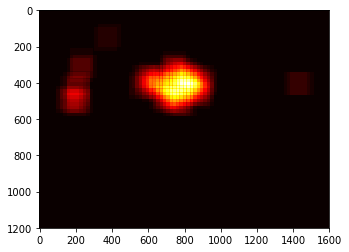

In [16]:
image = cv2.imread('vase-1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
labels = create_heatmap(hot_windows, image.shape)
plt.imshow(labels, cmap='hot')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


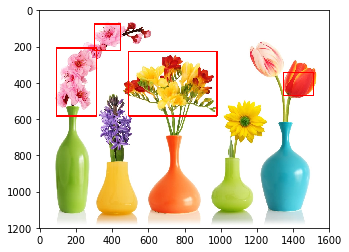

In [17]:
image = cv2.imread('vase-1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
hot_windows = combine_boxes(hot_windows, image.shape)
copy_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


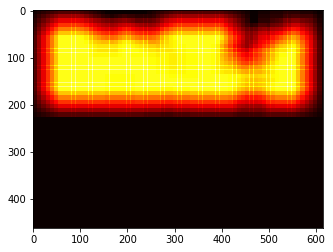

In [18]:
image = cv2.imread('1371611659609.jpeg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
labels = create_heatmap(hot_windows, image.shape)
plt.imshow(labels, cmap='hot')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


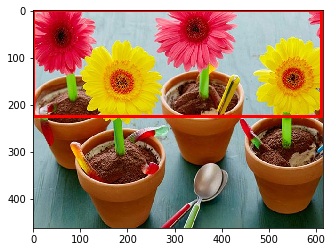

In [19]:
image = cv2.imread('1371611659609.jpeg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
hot_windows = combine_boxes(hot_windows, image.shape)
copy_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


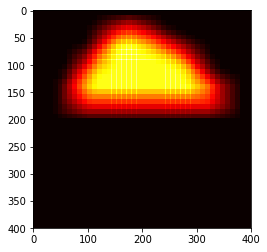

In [20]:
image = cv2.imread('0030126.jpeg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
labels = create_heatmap(hot_windows, image.shape)
plt.imshow(labels, cmap='hot')
plt.show()

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


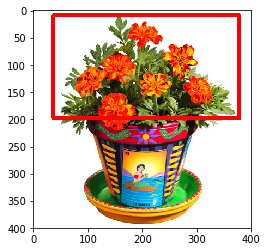

In [21]:
image = cv2.imread('0030126.jpeg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
hot_windows = combine_boxes(hot_windows, image.shape)
copy_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
import pickle
f = open('scaler.p', 'wb')
pickle.dump(X_scaler, f, protocol=2)
f.close()     

In [23]:
f = open('clf.p', 'wb')
pickle.dump(clf, f,protocol=2)
f.close()  

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


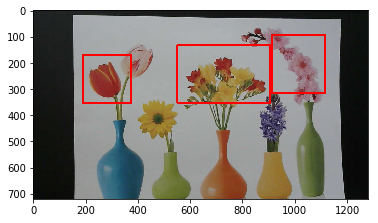

In [26]:
image = cv2.imread('2017-10-29-162233.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[0, image.shape[0] / 2], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85), parallel = False)
hot_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)
hot_windows = combine_boxes(hot_windows, image.shape)
copy_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
plt.show()